### Import packages

In [1]:
import os
import ee
import geemap
import matplotlib.pyplot as plt
from geemap import cartoee
from zipfile import ZipFile
from urllib.request import urlretrieve
# from urllib.parse import urljoin
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from pprint import pprint
from datetime import datetime as dt
from datetime import date
import pandas as pd

In [2]:
ee.Initialize()

### Import country borders from GEE collection and subset EU

In [3]:
world = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
# subset EU
eu = world.filter(ee.Filter.eq('wld_rgn', 'Europe'))
eu = eu.filter(ee.Filter.eq('country_na', 'Russia').Not())
eu = eu.filter(ee.Filter.eq('country_na', 'Svalbard').Not())
cyp = world.filter(ee.Filter.eq('country_na', 'Cyprus'))
eu = ee.FeatureCollection(eu.merge(cyp))
eu_size = eu.size()
print('Number of features in EU:', eu_size.getInfo())

# pprint(world.limit(1).getInfo()['features'][0]['properties'])

Number of features in EU: 53


In [4]:
# Add area column for each country
def addAreakm2(feature):
    return feature.set({'areakm2' : feature.geometry().area().divide(1000 * 1000)})
eu = eu.map(addAreakm2)
# pprint(eu.limit(1).getInfo()['features'][0]['properties'])

print('Descriptive stats of EU country size:')
pprint(eu.aggregate_stats('areakm2'). getInfo())

Descriptive stats of EU country size:
{'max': 595908.9587958328,
 'mean': 110423.16327273987,
 'min': 0.5227166356781738,
 'sample_sd': 154656.389193081,
 'sample_var': 23918598718.241745,
 'sum': 5852427.653455213,
 'sum_sq': 1890010707667.9536,
 'total_count': 53,
 'total_sd': 153190.41876959283,
 'total_var': 23467304402.803223,
 'valid_count': 53,
 'weight_sum': 53,
 'weighted_sum': 5852427.653455213}


### Initialize map centered on EU

In [5]:
# initialize map
center_map = [48, 8]
zoom_default = 3
map0 = geemap.Map(center=center_map, zoom=zoom_default)
# add basemap
map0.add_basemap("CartoDB.DarkMatter")
# add country borders
map0.addLayer(eu, {}, "National boundaries")

### Import relavant satellite data collections

In [8]:
start_date = '2015-04-01'
end_date = date.today().strftime('%Y-%m-%d')

# subsurface soil moisture # 10km res - 2 or 3 days rev
susm = ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture")\
    .select("susm")\
    .filterDate(start_date, end_date)

susm_vparams = {
    "min": 0.0,
    "max": 274.6,
    "palette": ['ff0303', 'efff07', 'efff07', '418504', '0300ff']
}

# # import a land cover # all bands at 500 m res
# lcc = ee.ImageCollection('MODIS/006/MCD12Q1')\
#     .select("LC_Type1")\
#     .filterDate(start_date, end_date)

# lcc_vps = {
#     "min": 1.0,
#     "max": 17.0,
#     "palette": [
#         '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
#         'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
#         '69fff8', 'f9ffa4', '1c0dff'
#     ]
# }

# # import a land surface temperature # 1km res - 1 day rev
# lst = ee.ImageCollection('MODIS/006/MOD11A1')\
#     .select('LST_Day_1km')\
#     .filterDate(start_date, end_date)

# lst_vps = {
#     "min": 13000.0,
#     "max": 16500.0,
#     "palette": [
#         '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
#         '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
#         '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
#         'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
#         'ff0000', 'de0101', 'c21301', 'a71001', '911003'
#     ]
# }


# # import a ground elevation - 30m res
# srtm = ee.Image('USGS/SRTMGL1_003')

### Explore SMAP collection

In [9]:
# Get number of images
size = susm.size()

# Gate date range
rango = susm.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])

init_date = ee.Date(rango.get('min')).getInfo()['value']/1000.
init_date_f = dt.utcfromtimestamp(init_date).strftime('%Y-%m-%d %H:%M:%S')

last_date = ee.Date(rango.get('max')).getInfo()['value']/1000.
last_date_f = dt.utcfromtimestamp(last_date).strftime('%Y-%m-%d %H:%M:%S')

print('N images in SMAP collection:', size.getInfo(), '\nDate range SMAP: ', init_date_f, ' - ', last_date_f) 

N images in SMAP collection: 739 
Date range SMAP:  2015-04-02 12:00:00  -  2021-04-24 12:00:00


### Clip image on EU

In [11]:
susm1 = susm.first()
susm1_eu = susm1.clip(eu)
map0.addLayer(susm1_eu, susm_vparams, 'SMAP Img1 EU')
map0

Map(center=[48, 8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Extract data for time series analysis

In [14]:
# test function on single image
meanReg = susm1.reduceRegions(
    reducer=ee.Reducer.mean(), 
    collection=eu, 
    scale=10000)

print('Object type:', meanReg.name(), '\nProperties')
pprint(meanReg.limit(1).getInfo()['features'][0]['properties'])

Object type: FeatureCollection 
Properties
{'abbreviati': 'Ukr.',
 'areakm2': 595908.9587958328,
 'country_co': 'UP',
 'country_na': 'Ukraine',
 'mean': 105.05070243393943,
 'wld_rgn': 'Europe'}


In [13]:
map0.addLayer(meanReg, {}, "Avg SMAP Img1 by EU country")

In [16]:
# map function over ImageCollection
def regMean(image):
    return image.reduceRegions(
        reducer=ee.Reducer.mean(),
        collection=eu,
        scale=10000)

susm_mean = susm.map(regMean)
print('Object type:', susm_mean.name())

Object type: ImageCollection


In [22]:
susm_mean.propertyNames().getInfo()

['date_range',
 'period',
 'type_name',
 'max_mirrored_version',
 'thumb',
 'description',
 'source_tags',
 'system:id',
 'visualization_0_max',
 'provider_url',
 'title',
 'sample',
 'tags',
 'product_tags',
 'visualization_0_palette',
 'provider',
 'visualization_0_min',
 'system:version',
 'visualization_0_name',
 'visualization_0_bands']

In [19]:
susm_m1 = susm_mean.first()
print('Object type:', susm_m1.name())

Object type: Image


In [23]:
susm_m1.propertyNames().getInfo()

['system:index']

### Define space units for time series analysis

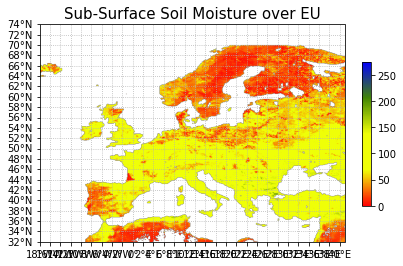

In [10]:
# xmin, ymin, xmax, ymax 
eu_bbox = [-18, 32, 41, 74]

susm1 = susm.first()
# Check grid size for spatial re-sampling
ax = cartoee.get_map(susm1, region=eu_bbox, vis_params=susm_vparams)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[2, 2], linestyle=":")
# add colorbar
cartoee.add_colorbar(ax, susm_vparams, loc='right')
# set title
ax.set_title(label='Sub-Surface Soil Moisture over EU', fontsize=15)
plt.show()